# How To Build Agents?

<img src="https://raw.githubusercontent.com/arad1367/UniLi_sources/main/IMG/logo.jpg"
     alt="University of Liechtenstein"
     width="350"
     height="auto">

### About This Tutorial

This tutorial is prepared by **Dr. Pejman Ebrahimi** for the "Deep Learning and Advanced AI Techniques" course at the University of Liechtenstein.

For more resources and notebooks related to this course, please visit Moodle or GitHub repository: [Course Materials](https://github.com/arad1367/University-of-Liechtenstein/tree/main/Deep%20Learning%20and%20Advanced%20AI).

You can reach out to Dr. Pejman Ebrahimi via email: [pejman.ebrahimi@uni.li](mailto:pejman.ebrahimi@uni.li).

# 1. OpenAI Agents SDK

> The OpenAI Agents SDK enables you to build agentic AI apps in a lightweight, easy-to-use package with very few abstractions. It's a production-ready upgrade of our previous experimentation for agents, Swarm. The Agents SDK has a very small set of primitives:

- `Agents`, which are LLMs equipped with instructions and tools
- `Handoffs`, which allow agents to delegate to other agents for specific tasks
- `Guardrails`, which enable the inputs to agents to be validated
In combination with Python, these primitives are powerful enough to express complex relationships between tools and agents, and allow you to build real-world applications without a steep learning curve. In addition, the SDK comes with built-in tracing that lets you visualize and debug your agentic flows, as well as evaluate them and even fine-tune models for your application.

# Why use the Agents SDK?

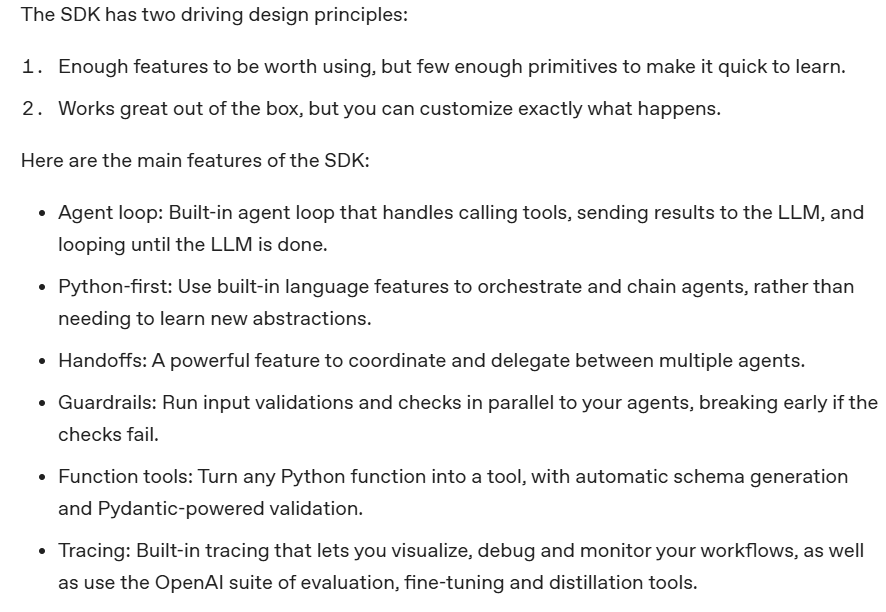

In [1]:
# Installation
!pip install openai-agents

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.9/116.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.3/129.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.5/119.5 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.6 MB/s eta 0:00:00


In [23]:
# In colab
import os
from google.colab import userdata

api_key = userdata.get('OPENAI_API_KEY')
if api_key:
    os.environ["OPENAI_API_KEY"] = api_key
else:
    raise ValueError("API key not found in userdata.")


In [8]:
# In VsCode

# !export OPENAI_API_KEY=sk-...
# or .env
# from dotenv import load_dotenv

# load_dotenv()

In [ ]:
# Flight customer service agent

from __future__ import annotations as _annotations

import asyncio
import random
import uuid

from pydantic import BaseModel

from agents import (
    Agent,
    HandoffOutputItem,
    ItemHelpers,
    MessageOutputItem,
    RunContextWrapper,
    Runner,
    ToolCallItem,
    ToolCallOutputItem,
    TResponseInputItem,
    function_tool,
    handoff,
    trace,
)
from agents.extensions.handoff_prompt import RECOMMENDED_PROMPT_PREFIX

### CONTEXT
class AirlineAgentContext(BaseModel):
    passenger_name: str | None = None
    confirmation_number: str | None = None
    seat_number: str | None = None
    flight_number: str | None = None


### TOOLS


@function_tool(
    name_override="faq_lookup_tool", description_override="Lookup frequently asked questions."
)
async def faq_lookup_tool(question: str) -> str:
    if "bag" in question or "baggage" in question:
        return (
            "You are allowed to bring one bag on the plane. "
            "It must be under 50 pounds and 22 inches x 14 inches x 9 inches."
        )
    elif "seats" in question or "plane" in question:
        return (
            "There are 120 seats on the plane. "
            "There are 22 business class seats and 98 economy seats. "
            "Exit rows are rows 4 and 16. "
            "Rows 5-8 are Economy Plus, with extra legroom. "
        )
    elif "wifi" in question:
        return "We have free wifi on the plane, join Airline-Wifi"
    return "I'm sorry, I don't know the answer to that question."


@function_tool
async def update_seat(
    context: RunContextWrapper[AirlineAgentContext], confirmation_number: str, new_seat: str
) -> str:
    """
    Update the seat for a given confirmation number.

    Args:
        confirmation_number: The confirmation number for the flight.
        new_seat: The new seat to update to.
    """
    # Update the context based on the customer's input
    context.context.confirmation_number = confirmation_number
    context.context.seat_number = new_seat
    # Ensure that the flight number has been set by the incoming handoff
    assert context.context.flight_number is not None, "Flight number is required"
    return f"Updated seat to {new_seat} for confirmation number {confirmation_number}"


### HOOKS


async def on_seat_booking_handoff(context: RunContextWrapper[AirlineAgentContext]) -> None:
    flight_number = f"FLT-{random.randint(100, 999)}"
    context.context.flight_number = flight_number


### AGENTS

faq_agent = Agent[AirlineAgentContext](
    name="FAQ Agent",
    handoff_description="A helpful agent that can answer questions about the airline.",
    instructions=f"""{RECOMMENDED_PROMPT_PREFIX}
    You are an FAQ agent. If you are speaking to a customer, you probably were transferred to from the triage agent.
    Use the following routine to support the customer.
    # Routine
    1. Identify the last question asked by the customer.
    2. Use the faq lookup tool to answer the question. Do not rely on your own knowledge.
    3. If you cannot answer the question, transfer back to the triage agent.""",
    tools=[faq_lookup_tool],
)

seat_booking_agent = Agent[AirlineAgentContext](
    name="Seat Booking Agent",
    handoff_description="A helpful agent that can update a seat on a flight.",
    instructions=f"""{RECOMMENDED_PROMPT_PREFIX}
    You are a seat booking agent. If you are speaking to a customer, you probably were transferred to from the triage agent.
    Use the following routine to support the customer.
    # Routine
    1. Ask for their confirmation number.
    2. Ask the customer what their desired seat number is.
    3. Use the update seat tool to update the seat on the flight.
    If the customer asks a question that is not related to the routine, transfer back to the triage agent. """,
    tools=[update_seat],
)

triage_agent = Agent[AirlineAgentContext](
    name="Triage Agent",
    handoff_description="A triage agent that can delegate a customer's request to the appropriate agent.",
    instructions=(
        f"{RECOMMENDED_PROMPT_PREFIX} "
        "You are a helpful triaging agent. You can use your tools to delegate questions to other appropriate agents."
    ),
    handoffs=[
        faq_agent,
        handoff(agent=seat_booking_agent, on_handoff=on_seat_booking_handoff),
    ],
)

faq_agent.handoffs.append(triage_agent)
seat_booking_agent.handoffs.append(triage_agent)


### RUN


async def main():
    current_agent: Agent[AirlineAgentContext] = triage_agent
    input_items: list[TResponseInputItem] = []
    context = AirlineAgentContext()

    # Normally, each input from the user would be an API request to your app, and you can wrap the request in a trace()
    # Here, we'll just use a random UUID for the conversation ID
    conversation_id = uuid.uuid4().hex[:16]

    while True:
        user_input = input("Enter your message: ")
        with trace("Customer service", group_id=conversation_id):
            input_items.append({"content": user_input, "role": "user"})
            result = await Runner.run(current_agent, input_items, context=context)

            for new_item in result.new_items:
                agent_name = new_item.agent.name
                if isinstance(new_item, MessageOutputItem):
                    print(f"{agent_name}: {ItemHelpers.text_message_output(new_item)}")
                elif isinstance(new_item, HandoffOutputItem):
                    print(
                        f"Handed off from {new_item.source_agent.name} to {new_item.target_agent.name}"
                    )
                elif isinstance(new_item, ToolCallItem):
                    print(f"{agent_name}: Calling a tool")
                elif isinstance(new_item, ToolCallOutputItem):
                    print(f"{agent_name}: Tool call output: {new_item.output}")
                else:
                    print(f"{agent_name}: Skipping item: {new_item.__class__.__name__}")
            input_items = result.to_input_list()
            current_agent = result.last_agent


if __name__ == "__main__":
    asyncio.run(main())

# 2. smolagent

In [31]:
!pip install smolagents[toolkit]

In [32]:
from huggingface_hub import login

login()

In [33]:
from smolagents import CodeAgent, DuckDuckGoSearchTool, HfApiModel

agent = CodeAgent(tools=[DuckDuckGoSearchTool()], model=HfApiModel())

agent.run("Which programming languages do I need to learn to become a great AI engineer in 2025?")


╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Which programming languages do I need to learn to become a great AI engineer in 2025?                           │
│                                                                                                                 │
╰─ HfApiModel - Qwen/Qwen2.5-Coder-32B-Instruct ──────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  search_results = web_search(query="programming languages for AI engineer 2025")                                  
  print(search_results)                                                                                            
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
## Search Results

[Top 10 AI Programming Languages to Master in 
2025](https://www.pravaahconsulting.com/post/best-ai-programming-languages)
Explore the leading programming languages shaping AI development in 2025. Stay ahead in the tech revolution by 
mastering these essential tools for innovation. Imagine a world where machines can learn, adapt, and interact with 
humans in ways that were once the realm of science fiction.

[Top AI Programming Languages in 2025: A Comprehensive 
Guide](https://digiscorp.com/top-ai-programming-languages-in-2025-a-comprehensive-guide/)
The choice of programming language directly impacts: Development Speed: How quickly you can build and test AI 
models.; Performance: The efficiency of algorithms and computations.; Flexibility: The ability to integrate with 
libraries and frameworks.; Community Support: Availability of resources and tools.; Each language offers unique 
advantages for different AI applications, such as machine ...

[10 Best AI Programming Languages To Know in 2025 - 
Upwork](https://www.upwork.com/resources/best-ai-programming-language)
However, other programming languages like Java, C++, and Haskell also play a fundamental role in creating AI 
systems. Read on as we discuss the top AI programming languages in detail and explain how to choose a suitable 
language for your next AI project. 1. Python. One of the most popular programming languages in AI development is 
Python. It ...

[Top 10 AI Programming Languages to Know in 2025](https://www.appliedaicourse.com/blog/ai-programming-languages/)
Artificial Intelligence (AI) programming has become central to technological advancements across industries. This 
article highlights the top 10 programming languages shaping the AI landscape in 2025. These languages are essential
for tasks like machine learning, natural language processing, and robotics, offering diverse tools and frameworks 
to streamline AI development. Overview of the Best ...

[Best AI Programming Languages to Use in 2025 - 
capitalnumbers.com](https://www.capitalnumbers.com/blog/best-ai-programming-languages/)
Artificial Intelligence (AI) continues to transform industries, and selecting the right programming language is 
crucial for effective AI development in 2025.The top programming languages for AI this year include Python, 
renowned for its extensive libraries and ease of use; Java, valued for its scalability and performance; C++, 
preferred for high-performance applications; Julia, emerging for ...

[Top 10 AI Programming Languages You Need to Know in 
2025](https://shivlab.com/blog/top-ai-programming-languages-comprehensive-guide/)
The best AI languages offer efficiency, scalability, and support for machine learning frameworks. Here are the top 
10 AI programming languages to learn for future-ready AI development. 1. Python. Python is the most widely used 
programming language for artificial intelligence. It is known for its simplicity, readability, and extensive 
library ...

[Top AI Programming Languages to Learn in 2025 - 
prodgrade.com](https://prodgrade.com/artificial-intelligence/ai-programming-languages-2025/)
H2: Introduction to AI Programming Languages. H2: Top AI Programming Languages to Learn in 2025. H2: Natural 
Language Programming: The Future of AI Coding. H2: How to Choose the Right AI Programming Language for Your 
Project. H2: Trends in AI Programming Languages for 2025 and Beyond. H2: Conclusion. H2: FAQS

[AI Programming Languages: Top 10 for 2025 - 
tuvoc.com](https://www.tuvoc.com/blog/top-10-ai-programming-languages-to-learn-for-a-successful-career-in-2025/)
Discover the top 10 AI programming languages to learn in 2025 and boost your career. Artificial intelligence (AI) 
is more than just some buzzword now, it is actually driving the change and is enabling industries to make smarter 
decisions, boosting productivity levels, and even reducing costs (from operational costs to marginal costs).

[2025's Top 10 AI Programming L

[Step 1: Duration 6.01 seconds| Input tokens: 2,058 | Output tokens: 90]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  import re                                                                                                        
  from collections import Counter                                                                                  
                                                                                                                   
  # Define possible programming languages to look for                                                              
  languages = ['python', 'java', 'c++', 'julia', 'r', 'scala', 'go', 'ruby', 'rust', 'typescript', 'javascript',   
  'kotlin']                                                                                                        
                                                                                                                   
  # Combine all search results into a single string                                                                
  search_results_str = '\n'.join(search_results)                                                                   
                                                                                                                   
  # Convert to lowercase for uniformity                                                                            
  search_results_str = search_results_str.lower()                                                                  
                                                                                                                   
  # Use regular expressions to find mentions of each language                                                      
  language_counter = Counter()                                                                                     
  for language in languages:                                                                                       
      matches = re.findall(r'\b' + language + r'\b', search_results_str)                                           
      language_counter[language] += len(matches)                                                                   
                                                                                                                   
  # Print the sorted list of languages by frequency                                                                
  print(dict(language_counter))                                                                                    
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
{'python': 0, 'java': 0, 'c++': 128, 'julia': 0, 'r': 256, 'scala': 0, 'go': 0, 'ruby': 0, 'rust': 0, 'typescript':
0, 'javascript': 0, 'kotlin': 0}

Out: None

[Step 2: Duration 14.20 seconds| Input tokens: 5,355 | Output tokens: 312]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 3 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  import re                                                                                                        
  from collections import Counter                                                                                  
                                                                                                                   
  # Define possible programming languages to look for                                                              
  languages = ['python', 'java', 'c++', 'julia', 'r', 'scala', 'go', 'ruby', 'rust', 'typescript', 'javascript',   
  'kotlin']                                                                                                        
                                                                                                                   
  # Combine all search results into a single string                                                                
  search_results_str = '\n'.join(search_results)                                                                   
                                                                                                                   
  # Convert to lowercase for uniformity                                                                            
  search_results_str = search_results_str.lower()                                                                  
                                                                                                                   
  # Use regular expressions to find mentions of each language with improved pattern matching                       
  language_counter = Counter()                                                                                     
  for language in languages:                                                                                       
      # Handle special cases like 'c++'                                                                            
      if language == 'c++':                                                                                        
          matches = re.findall(r'\b' + re.escape(language) + r'\b', search_results_str)                            
      else:                                                                                                        
          matches = re.findall(r'\b' + language + r'\b', search_results_str)                                       
      language_counter[language] += len(matches)                                                                   
                                                                                                                   
  # Print the sorted list of languages by frequency                                                                
  print(dict(language_counter))                                                                                    
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
{'python': 0, 'java': 0, 'c++': 0, 'julia': 0, 'r': 256, 'scala': 0, 'go': 0, 'ruby': 0, 'rust': 0, 'typescript': 
0, 'javascript': 0, 'kotlin': 0}

Out: None

[Step 3: Duration 14.69 seconds| Input tokens: 9,188 | Output tokens: 606]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 4 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  # Define possible programming languages to look for                                                              
  languages = ['python', 'java', 'c++', 'julia', 'r', 'scala', 'go', 'ruby', 'rust', 'typescript', 'javascript',   
  'kotlin']                                                                                                        
                                                                                                                   
  # Combine all search results into a single string and convert to lowercase for uniformity                        
  search_results_str = '\n'.join(search_results).lower()                                                           
                                                                                                                   
  # Initialize a counter for languages                                                                             
  language_counter = {language: 0 for language in languages}                                                       
                                                                                                                   
  # Count mentions of each language                                                                                
  for language in languages:                                                                                       
      if language == 'c++':                                                                                        
          language_counter[language] += search_results_str.count('c++')                                            
      else:                                                                                                        
          language_counter[language] += search_results_str.count(language)                                         
                                                                                                                   
  # Print the sorted list of languages by frequency                                                                
  print(dict(language_counter))                                                                                    
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
{'python': 0, 'java': 0, 'c++': 0, 'julia': 0, 'r': 256, 'scala': 0, 'go': 0, 'ruby': 0, 'rust': 0, 'typescript': 
0, 'javascript': 0, 'kotlin': 0}

Out: None

[Step 4: Duration 14.20 seconds| Input tokens: 13,682 | Output tokens: 862]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 5 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  search_results = web_search(query="programming languages for AI engineer 2025 with focus")                       
  print(search_results)                                                                                            
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
## Search Results

[Top 10 AI Programming Languages to Know in 2025](https://www.appliedaicourse.com/blog/ai-programming-languages/)
Artificial Intelligence (AI) programming has become central to technological advancements across industries. This 
article highlights the top 10 programming languages shaping the AI landscape in 2025. These languages are essential
for tasks like machine learning, natural language processing, and robotics, offering diverse tools and frameworks 
to streamline AI development. Overview of the Best ...

[Top 10 AI Programming Languages to Master in 
2025](https://www.pravaahconsulting.com/post/best-ai-programming-languages)
Explore the leading programming languages shaping AI development in 2025. Stay ahead in the tech revolution by 
mastering these essential tools for innovation. Imagine a world where machines can learn, adapt, and interact with 
humans in ways that were once the realm of science fiction.

[Top AI Programming Languages in 2025: A Comprehensive 
Guide](https://digiscorp.com/top-ai-programming-languages-in-2025-a-comprehensive-guide/)
The choice of programming language directly impacts: Development Speed: How quickly you can build and test AI 
models.; Performance: The efficiency of algorithms and computations.; Flexibility: The ability to integrate with 
libraries and frameworks.; Community Support: Availability of resources and tools.; Each language offers unique 
advantages for different AI applications, such as machine ...

[10 Best AI Programming Languages To Know in 2025 - 
Upwork](https://www.upwork.com/resources/best-ai-programming-language)
However, other programming languages like Java, C++, and Haskell also play a fundamental role in creating AI 
systems. Read on as we discuss the top AI programming languages in detail and explain how to choose a suitable 
language for your next AI project. 1. Python. One of the most popular programming languages in AI development is 
Python. It ...

[Best AI Programming Languages to Use in 2025 - 
capitalnumbers.com](https://www.capitalnumbers.com/blog/best-ai-programming-languages/)
Artificial Intelligence (AI) continues to transform industries, and selecting the right programming language is 
crucial for effective AI development in 2025.The top programming languages for AI this year include Python, 
renowned for its extensive libraries and ease of use; Java, valued for its scalability and performance; C++, 
preferred for high-performance applications; Julia, emerging for ...

[Top 10 AI Programming Languages You Need to Know in 2025 - Zealous 
System](https://www.zealousys.com/blog/top-ai-programming-languages/)
In conclusion, mastering these top 10 AI programming languages is essential for anyone looking to be an expert in 
artificial intelligence in 2025 and beyond. Whether you're a data scientist, machine learning engineer, or AI 
researcher, familiarity with these languages will empower you to tackle a wide range of AI challenges and drive ...

[Top 10 AI Programming Languages You Need to Know in 
2025](https://shivlab.com/blog/top-ai-programming-languages-comprehensive-guide/)
The best AI languages offer efficiency, scalability, and support for machine learning frameworks. Here are the top 
10 AI programming languages to learn for future-ready AI development. 1. Python. Python is the most widely used 
programming language for artificial intelligence. It is known for its simplicity, readability, and extensive 
library ...

[Top Programming Languages for Career Growth 2025 - 
coders.dev](https://www.coders.dev/blog/best-programming-languages-in-2025-.html)
Discover the best programming languages to learn in 2025 that offer strong job prospects, high salaries, and 
future-proof skills for developers of all levels. ... Focus on your Major Objectives and Leave the Rest to Us 
Dedicated Teams: ... engineering, and AI. It combines the speed of languages like C with the simplicity of Python, 
allowing ...

[AI Programming Lan

[Step 5: Duration 8.79 seconds| Input tokens: 18,747 | Output tokens: 1,003]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 6 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  import re                                                                                                        
  from collections import Counter                                                                                  
                                                                                                                   
  # Define possible programming languages to look for                                                              
  languages = ['python', 'java', 'c++', 'julia', 'r', 'scala', 'go', 'ruby', 'rust', 'typescript', 'javascript',   
  'kotlin']                                                                                                        
                                                                                                                   
  # Combine all search results into a single string and convert to lowercase for uniformity                        
  search_results_str = '\n'.join(search_results).lower()                                                           
                                                                                                                   
  # Use regular expressions to find mentions of each language with improved pattern matching                       
  language_counter = Counter()                                                                                     
  for language in languages:                                                                                       
      # Handle special cases like 'c++'                                                                            
      if language == 'c++':                                                                                        
          matches = re.findall(r'\b' + re.escape(language) + r'\b', search_results_str)                            
      else:                                                                                                        
          matches = re.findall(r'\b' + language + r'\b', search_results_str)                                       
      language_counter[language] += len(matches)                                                                   
                                                                                                                   
  # Print the sorted list of languages by frequency                                                                
  print(dict(language_counter))                                                                                    
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
{'python': 0, 'java': 0, 'c++': 0, 'julia': 0, 'r': 245, 'scala': 0, 'go': 0, 'ruby': 0, 'rust': 0, 'typescript': 
0, 'javascript': 0, 'kotlin': 0}

Out: None

[Step 6: Duration 18.40 seconds| Input tokens: 25,088 | Output tokens: 1,319]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 7 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  final_answer(["Python", "Java", "C++", "R", "Julia"])                                                            
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: ['Python', 'Java', 'C++', 'R', 'Julia']

[Step 7: Duration 11.79 seconds| Input tokens: 32,102 | Output tokens: 1,558]

['Python', 'Java', 'C++', 'R', 'Julia']